### Machine Learning Exercise

#### Merge Datasets

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import warnings
import pickle

# File path
excel_file_path = 'Excel_files/Task_Data_Scientist_Dataset.xlsx'

# Make excel sheets into dataframes
df_sheet2 = pd.read_excel(excel_file_path, sheet_name='Soc_Dem')
df_sheet3 = pd.read_excel(excel_file_path, sheet_name='Products_ActBalance')
df_sheet4 = pd.read_excel(excel_file_path, sheet_name='Inflow_Outflow')
df_sheet5 = pd.read_excel(excel_file_path, sheet_name='Sales_Revenues')

# Merging the Dataframes based on the column 'Client'
df = pd.merge(df_sheet2, df_sheet3, on='Client', how='outer')
df= pd.merge(df, df_sheet4, on='Client', how='outer')

# Distinguish the full merged dataset and the individual one accounting for 60% of the training set
df_merge = pd.merge(df, df_sheet5, on='Client', how='outer')

display(df_merge.shape)
display(df_merge.head())

(1615, 36)

,Client,Sex,Age,Tenure,Count_CA,Count_SA,Count_MF,Count_OVD,Count_CC,Count_CL,...,TransactionsDeb_CA,TransactionsDebCash_Card,TransactionsDebCashless_Card,TransactionsDeb_PaymentOrder,Sale_MF,Sale_CC,Sale_CL,Revenue_MF,Revenue_CC,Revenue_CL
0,909,M,21,27,1,NaN,NaN,1.0,NaN,1.0,...,7.0,1.0,0.0,4.0,NaN,NaN,NaN,NaN,NaN,NaN
1,1217,M,38,165,1,NaN,NaN,NaN,NaN,NaN,...,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.000000,0.000000,0.0
2,850,F,49,44,1,NaN,NaN,NaN,NaN,NaN,...,6.0,0.0,0.0,1.0,0.0,1.0,0.0,0.000000,0.893929,0.0
3,1473,M,54,34,1,1.0,NaN,NaN,1.0,1.0,...,38.0,1.0,26.0,11.0,1.0,0.0,0.0,4.929643,0.000000,0.0
4,1038,M,29,106,1,NaN,NaN,NaN,NaN,NaN,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0


#### Exploratory Data Analysis

##### Dataset Cleaning

In [2]:
# Verify duplicate rows
duplicate_rows = df_merge.duplicated().sum()
print('Total number of duplicate rows:',duplicate_rows)

Total number of duplicate rows: 0


In [3]:
# Replace missing values with 0
df_merge = df_merge.replace(np.nan,0)

In [4]:
# Create dummy variables for Sex
df_merge['Sex'] = df_merge['Sex'].replace({'M': 1, 'F': 0}).astype(int)


In [5]:
df_merge[df_merge.columns].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1615 entries, 0 to 1614
Data columns (total 36 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   Client                        1615 non-null   int64  
 1   Sex                           1615 non-null   int64  
 2   Age                           1615 non-null   int64  
 3   Tenure                        1615 non-null   int64  
 4   Count_CA                      1615 non-null   int64  
 5   Count_SA                      1615 non-null   float64
 6   Count_MF                      1615 non-null   float64
 7   Count_OVD                     1615 non-null   float64
 8   Count_CC                      1615 non-null   float64
 9   Count_CL                      1615 non-null   float64
 10  ActBal_CA                     1615 non-null   float64
 11  ActBal_SA                     1615 non-null   float64
 12  ActBal_MF                     1615 non-null   float64
 13  Act

In [6]:
''' Missing Values '''

percent_missing = round(df_merge.isnull().sum() * 100 / len(df),2)
missing_value_df = pd.DataFrame({'Missing_Percentage': percent_missing})
missing_value_df.sort_values(by="Missing_Percentage",ascending=False)

,Missing_Percentage
Client,0.0
Sex,0.0
VolumeDeb,0.0
VolumeDeb_CA,0.0
VolumeDebCash_Card,0.0
VolumeDebCashless_Card,0.0
VolumeDeb_PaymentOrder,0.0
TransactionsDeb,0.0
TransactionsDeb_CA,0.0
TransactionsDebCash_Card,0.0


##### Visualisation

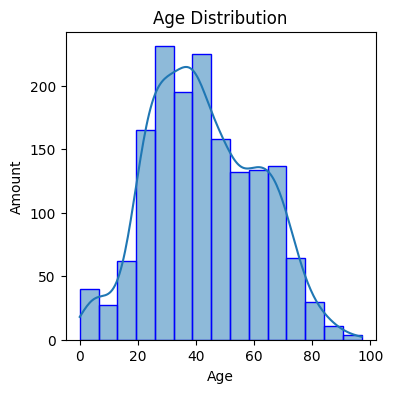

In [7]:
''' Age: Review the age distribution '''

plt.figure(figsize=(4, 4))

sns.histplot(df_merge['Age'], bins=15, edgecolor="b", kde=True)

plt.title('Age Distribution')
plt.xlabel('Age')
plt.ylabel('Amount')

plt.show()


There seem to be ages that are quite young for holding accounts at the bank. Hence, I can assume that these values are erroneous.
Here, I will verify how many clients are younger than 10 years old (min. age account opening in Belgium). 
Moreover, I will verify whether there are irregularities of 'Tenure' being larger than the actual age of a client as well.

In [8]:
# Verify the rows where Age is less than 10 years old
age_threshold = df_merge['Age'] < 10
print("Underage clients:", age_threshold.sum())

Underage clients: 51


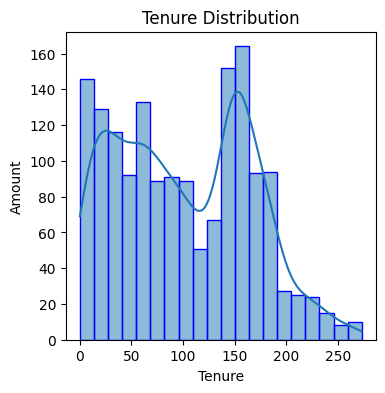

In [9]:
plt.figure(figsize=(4, 4))

sns.histplot(df_merge['Tenure'], bins=20, edgecolor="b", kde=True)

plt.title('Tenure Distribution')
plt.xlabel('Tenure')
plt.ylabel('Amount')

plt.show()

In [10]:
''' Tenure: Verify when tenure in years is larger than Age '''

anomaly_tenure = df_merge['Tenure']/12 > df_merge['Age']

print("Number of Tenure anomalies:", anomaly_tenure.sum())

Number of Tenure anomalies: 47


In [11]:
''' adjust the ages of the clients and tenure and put in dataset to excel'''

# Create Merged excel file
#current_directory = os.getcwd()
output_folder_path = 'Excel_files'

# Generating a new excel file with the corresponding excel folder
output_excel_path = os.path.join(output_folder_path, 'Merged_dataset.xlsx')

df_merge.to_excel(output_excel_path, index=False)

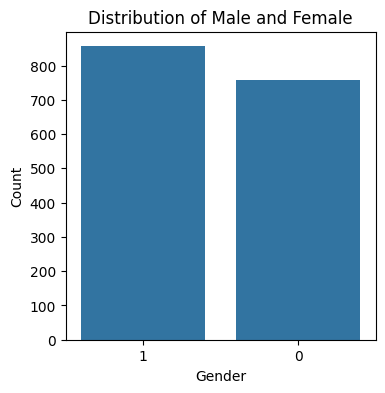

In [12]:
''' Gender: Review gender distribution'''

warnings.filterwarnings("ignore")

df_merge['Sex'] = df_merge['Sex'].astype(str)

plt.figure(figsize=(4, 4))
sns.countplot(x='Sex', data=df_merge)

plt.xlabel('Gender')
plt.ylabel('Count')
plt.title('Distribution of Male and Female')
plt.show()



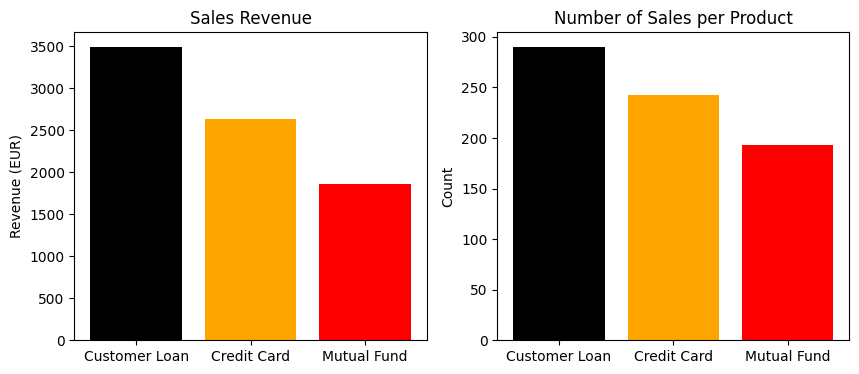

In [13]:
''' Sales Revenue: Compare the sales revenue per product '''

fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(10, 4))

# Sales Revenue
columns_revenue = np.arange(3)
revenue = [df_merge['Revenue_CL'].sum(), df_merge['Revenue_CC'].sum(), df_merge['Revenue_MF'].sum()]

ax1.bar(columns_revenue, revenue, align='center', color=["black", "orange", "red"])
ax1.set_xticks(columns_revenue)
ax1.set_xticklabels(['Customer Loan', 'Credit Card', 'Mutual Fund'])
ax1.set_ylabel('Revenue (EUR)')
ax1.set_title('Sales Revenue')

# Number of Sales per Product
columns_sales = np.arange(3)
sales = [df_merge['Sale_CL'].sum(), df_merge['Sale_CC'].sum(), df_merge['Sale_MF'].sum()]

ax2.bar(columns_sales, sales, align='center', color=["black", "orange", "red"])
ax2.set_xticks(columns_sales)
ax2.set_xticklabels(['Customer Loan', 'Credit Card', 'Mutual Fund'])
ax2.set_ylabel('Count')
ax2.set_title('Number of Sales per Product')

plt.show()


#### Training/Target Set Preparation

##### Target Set

In [14]:
client_focus = df_sheet5['Client']

df_40 = df_merge[~df_merge['Client'].isin(client_focus)]

df_40.shape

(646, 36)

In [15]:
df_40['Sex'] = df_40['Sex'].astype(int)

#### Training Set

In [16]:
# 60% conveying training set
df_train = df_merge[df_merge['Client'].isin(client_focus)]

display(df_train.shape)
display(df_train.head())

(969, 36)

,Client,Sex,Age,Tenure,Count_CA,Count_SA,Count_MF,Count_OVD,Count_CC,Count_CL,...,TransactionsDeb_CA,TransactionsDebCash_Card,TransactionsDebCashless_Card,TransactionsDeb_PaymentOrder,Sale_MF,Sale_CC,Sale_CL,Revenue_MF,Revenue_CC,Revenue_CL
1,1217,1,38,165,1,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.000000,0.000000,0.000000
2,850,0,49,44,1,0.0,0.0,0.0,0.0,0.0,...,6.0,0.0,0.0,1.0,0.0,1.0,0.0,0.000000,0.893929,0.000000
3,1473,1,54,34,1,1.0,0.0,0.0,1.0,1.0,...,38.0,1.0,26.0,11.0,1.0,0.0,0.0,4.929643,0.000000,0.000000
4,1038,1,29,106,1,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000
5,225,1,14,187,1,0.0,0.0,1.0,0.0,0.0,...,5.0,0.0,4.0,1.0,0.0,0.0,1.0,0.000000,0.000000,8.130714


#### Creation of Target Set

In [17]:
# Dataset for remaining 40% of clients for Consumer Loan
# clients_to_remove = df_sheet5['Client']

# df_40_cl = df[~df['Client'].isin(clients_to_remove)]

# df_40_cl.drop(['Count_CL', 'ActBal_CL'], inplace=True, axis=1)

# df_40_cl.head()

#### Creation of Training Set

In [18]:
# Create full training set for consumer loan
consumer_loan = ['Sale_MF','Sale_CC','Revenue_MF','Revenue_CC','Count_CL','ActBal_CL']
df_train_cl = df_train.drop(consumer_loan,axis=1)

# Create full training set for credit card
credit_card = ['Sale_MF','Sale_CL','Revenue_MF','Revenue_CL','Count_CC','ActBal_CC']
df_train_cc  = df_train.drop(credit_card,axis=1)

# Create full training set for mutual fund
mutual_fund = ['Sale_CC','Sale_CL','Revenue_CC','Revenue_CL','Count_MF','ActBal_MF']
df_train_mf = df_train.drop(mutual_fund,axis=1)

In [19]:
print(df_train_cl.shape)
print(df_train_cc.shape)
print(df_train_mf.shape)

(969, 30)
(969, 30)
(969, 30)


##### Imbalance of Datasets

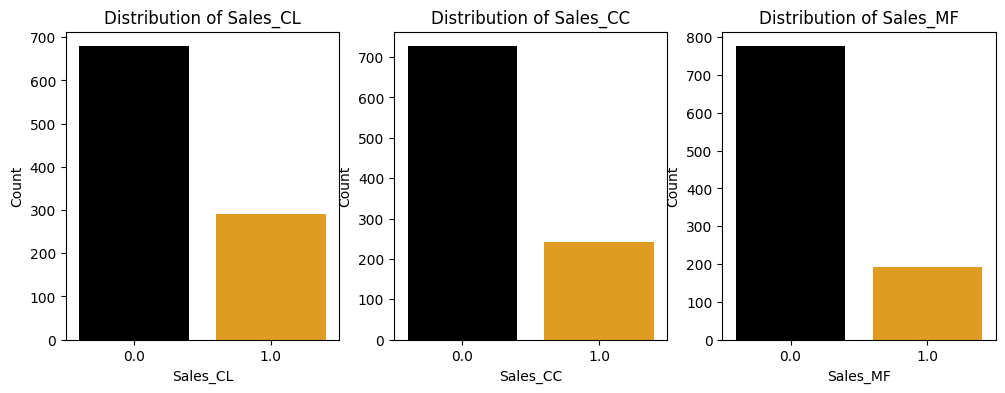

In [20]:
# Reviewing whether there is imbalance of the datasets

fig, (ax1, ax2, ax3) = plt.subplots(nrows=1, ncols=3, figsize=(12, 4))

# Sale_CL
sns.countplot(x='Sale_CL', data=df_train_cl, palette=["black", "orange"], ax=ax1)
ax1.set_xlabel('Sales_CL')
ax1.set_ylabel('Count')
ax1.set_title('Distribution of Sales_CL')

# Sale_CC
sns.countplot(x='Sale_CC', data=df_train_cc, palette=["black", "orange"], ax=ax2)
ax2.set_xlabel('Sales_CC')
ax2.set_ylabel('Count')
ax2.set_title('Distribution of Sales_CC')

# Sale_MF
sns.countplot(x='Sale_MF', data=df_train_mf, palette=["black", "orange"], ax=ax3)
ax3.set_xlabel('Sales_MF')
ax3.set_ylabel('Count')
ax3.set_title('Distribution of Sales_MF')

plt.show()


As can be seen from the bar charts, there is indeed the scenario of an imbalanced dataset. Herein, I will use methods such as Random Forests and GradientBoosting which are more robust towards imbalanced datasets. Moreover, I will use performance metrics such as precision, recall, F1-score and AUC, which are more suitable for similar datasets

#### Saving Datasets

In [21]:
directory_path = 'Pickle_Files'

os.makedirs(directory_path, exist_ok=True)

file_path1 = 'Pickle_Files/Customer_Loan.pkl'
file_path2 = 'Pickle_Files/Credit_Card.pkl'
file_path3 = 'Pickle_Files/Mutual_Fund.pkl'
file_path4 = 'Pickle_Files/40pct.pkl'

with open(file_path1, 'wb') as f1:
    pickle.dump(df_train_cl, f1)

with open(file_path2, 'wb') as f2:
    pickle.dump(df_train_cc, f2)

with open(file_path3, 'wb') as f3:
    pickle.dump(df_train_mf, f3)

with open(file_path4, 'wb') as f4:
    pickle.dump(df_40, f4)


#### Top 100 Clients for Marketing Outreach

In [22]:
with open('Pickle_Files/Revenue_MF.pkl', 'rb') as f5:
     mutual_fund= pickle.load(f5)
with open('Pickle_Files/Revenue_CC.pkl', 'rb') as f6:
     credit_card= pickle.load(f6)
with open('Pickle_Files/Revenue_CL.pkl', 'rb') as f7:
     consumer_loan= pickle.load(f7)

In [28]:
# Extract top 100 clients and their respective product
marketing_clients = pd.concat([mutual_fund, credit_card, consumer_loan])

marketing_clients.sort_values(by=['Revenue'], ascending=False,inplace=True)

marketing_clients.drop_duplicates(subset='Client', keep='first',inplace=True)

top_100_revenues = marketing_clients.head(100)

display(top_100_revenues['Product'].value_counts())
top_100_revenues

Product
CC    38
MF    34
CL    28
Name: count, dtype: int64

,Client,Revenue,Product
90,84,133.131639,CC
528,1073,96.356211,CC
459,1389,83.503807,CC
171,1460,82.448661,CC
415,940,59.423071,CC
...,...,...,...
89,382,10.353014,CC
95,1599,10.107725,CL
34,1063,10.046711,CL
185,1243,10.031614,CL


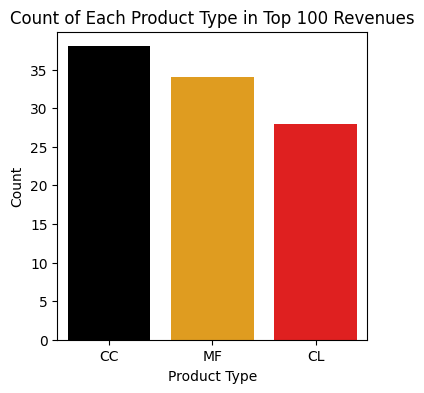

In [26]:
import seaborn as sns
import matplotlib.pyplot as plt

fig, ax1 = plt.subplots(nrows=1, ncols=1, figsize=(4, 4))

sns.countplot(x='Product', data=top_100_revenues, palette=["black", "orange", "red"], ax=ax1)
ax1.set_xlabel('Product Type')
ax1.set_ylabel('Count')
ax1.set_title('Count of Each Product Type in Top 100 Revenues')

plt.show()


In [25]:
# Potential Revenue Generated

print(f'Potential revenue to be generated: { int(top_100_revenues["Revenue"].sum())} EUR')

Potential revenue to be generated: 2276 EUR
